In [1]:
source("../data/env/variables.R")
source("~/wisdom/r/data_analysis_environment.R")
source("~/wisdom/r/clean_theme.R")
library(tidyr)
library(ggrepel)

# read switches
switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1 & IsFunctional==1 & Origin=="Tumor")

switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(Reliable==1 & IsFunctional==1 & Origin=="Tumor")

potus <- switches %>%
    select(GeneId,Symbol,Normal_transcript,Tumor_transcript, Recurrence,
           Affects_mutated_feature,PPI,Pannegative,Candidate)

# read drivers
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
  mutate(Tumor_type = ifelse(Tumor_type=="COREAD", "coad", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="HC", "lihc", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="RCCC", "kirc", Tumor_type),
         Tumor_type = tolower(Tumor_type) ) %>%
  set_colnames(c("Symbol","Tumor"))

# read expression
proteome <- read_tsv("../data/mutations/proteome_information.txt")

# read interactions
ppi.file <- "../data/eporta/raw_tables/Switched_interactions_consensus.txt"

## get max number of columns (necessary for reading)
no_col <- max(count.fields(ppi.file,sep = "\t"))
no_col.ppi <- (no_col-6)/2
ppi.cols <- paste(c("Origin","Interaction"), floor(seq(1,no_col.ppi,0.5)), sep="_")

## read table
ppi.split <- read.table(ppi.file,header=F,fill=T,col.names=1:no_col) %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol",ppi.cols)) %>%
    # all Origin columns contail "DDI_match", so we can disregard them
    select(-starts_with("Origin_")) %>%
    # convert from wide to long table format
    reshape2::melt(id.vars = c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerId","partnerSymbol"),
                   value.name = "Interaction") %>%
    select(-variable) %>%
    # remove cases with no interaction described
    filter(Interaction != "") %>%
    # split interaction information
    separate(Interaction, into = c("What","partnerTranscript","Pfams"), sep = "-") %>%
    mutate(What = plyr::revalue(What, replace = c("Gained"="Gain", "Lost"="Loss", "Kept"="Unaffected"))) %>%
    # remove pfams columns (account for different domains for the same interaction)
    select(-Pfams) %>%
    # remove several instances of the same isoform
    unique %>%
    # annotate with switch info
    merge(switches.split) %>%
    ## remove tumor specific measures
    select(-Recurrence,-Affects_mutated_feature,-PPI,-Pannegative) %>%
    merge(potus, by=c('GeneId','Symbol','Normal_transcript','Tumor_transcript','Candidate'), 
          suffixes=c(".split",".pancancer")) %>%
    # consider only the most abundant isoform as partner: one interaction per pair & only expressed genes
    merge(proteome, by.x = c("Tumor","partnerTranscript"), by.y = c("Tumor","Transcript"),
          suffixes = c(".switch",".partner"))

ppi <- ppi.split %>%
    group_by(GeneId.switch,Symbol.switch,Normal_transcript,Tumor_transcript,partnerSymbol) %>%
    
    summarise(Unaffected = sum(What=="Unaffected"), Gain = sum(What=="Gain"), Loss = sum(What=="Loss")) %>%
    ungroup() %>%
    set_colnames(c("GeneId","Symbol","Normal_transcript","Tumor_transcript","partnerSymbol","Unaffected","Gain","Loss")) %>%
    mutate(Tag = ifelse(Loss > 0, "Loss", "Unaffected"),
           Tag = ifelse(Gain > 0, "Gain", Tag)) %>%
    merge(switches)

ppiPalette = c("Gain" = "#31a354", "Loss" = "#f03b20", "Unaffected" = "#d9d9d9")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract

Warning message:
: attributes are not identical across measure variables; they will be dropped

# Tumor

In [2]:
# switches with ppi info
num.ppiSwitches <- ppi.split %>% select(Normal_transcript,Tumor_transcript) %>% unique %>% nrow
num.Switches <- switches.split %>% select(Normal_transcript,Tumor_transcript) %>% unique %>% nrow

num.ppiSwitches/num.Switches

[1] 0.2852439

Loading required package: RColorBrewer


,What,n,Proportion
1,Gain,1135,2.883711
2,Loss,7752,19.69562
3,Unaffected,30472,77.42067


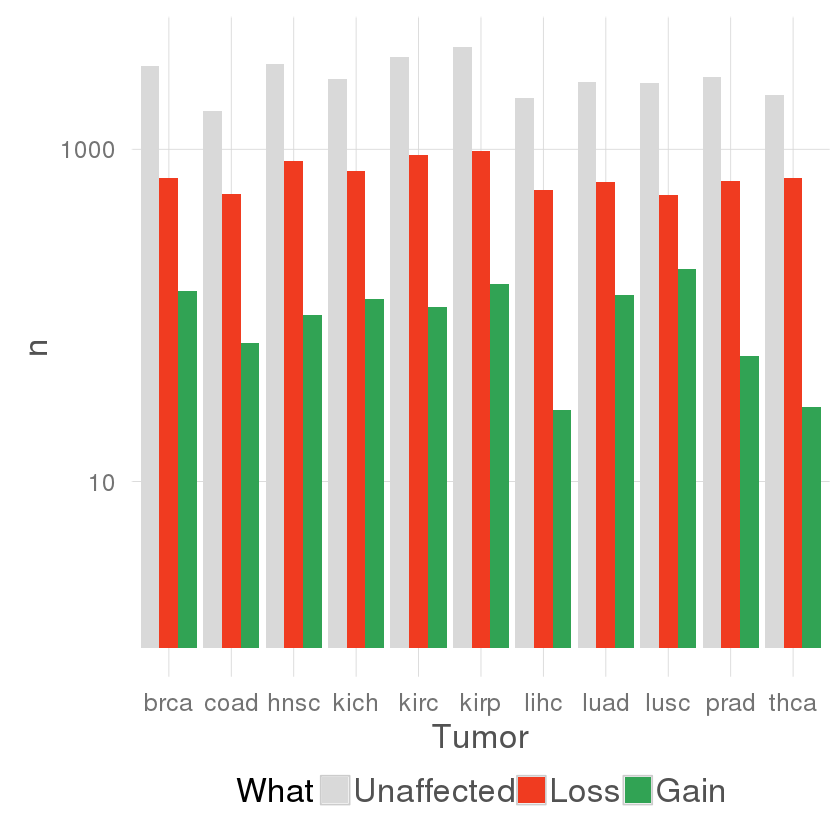

In [3]:
ppi.split %>%
    count(Tumor,What) %>%
    mutate(What = factor(What, levels = c("Unaffected","Loss","Gain"))) %>%
    ggplot(aes(x=Tumor, y=n, fill = What)) + 
        geom_bar(stat="identity",position="dodge") +
        scale_y_log10() +
        clean_theme() +
        theme(legend.position="bottom") +
        scale_fill_manual(values = ppiPalette) +
        labs(y="n", fill="What")

ppi.split %>%
    count(Tumor,What) %>%
    group_by(What) %>%
    summarise(n = sum(n)) %>%
    mutate(Proportion = n/sum(n) * 100)

## Trends across categories

We will check if the bulk of interactions tend to involve a switch in a particular set of genes eg drivers. We know that drivers, for several reasons, will have more interactions. However, a comparison between the proportions of "Kept" interactions and "Gained"/"Lost" should reveal differential behaviour.

## Drivers

### Tumor specific


Attaching package: ‘scales’

The following objects are masked from ‘package:readr’:

    col_factor, col_numeric




	Pearson's Chi-squared test

data:  .
X-squared = 376.34, df = 2, p-value < 2.2e-16


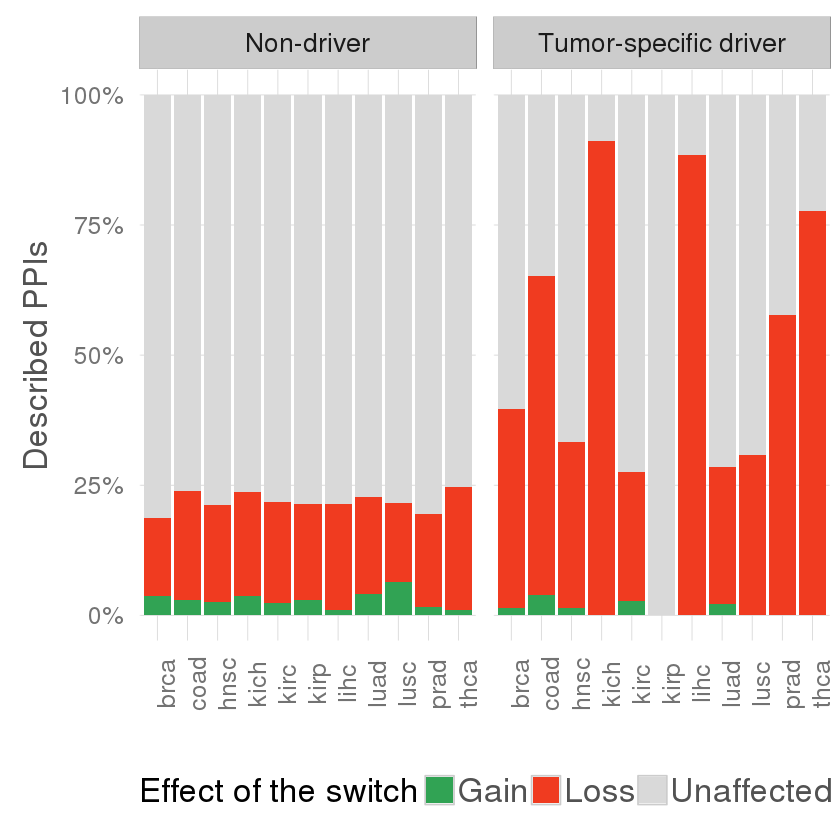

In [4]:
library(scales)

ppi.split %>%
    mutate(SpecificDriver = ifelse(SpecificDriver==1, "Tumor-specific driver", "Non-driver")) %>%
    ggplot(aes(x=Tumor, fill=What)) + 
        geom_bar(position="fill") +
        clean_theme() +
        labs(x="",y="Described PPIs",fill="Effect of the switch") +
        scale_fill_manual(values = ppiPalette) +
        theme(legend.position="bottom", axis.text.x = element_text(angle = 90)) +
        scale_y_continuous(labels = percent) +
        facet_grid(.~SpecificDriver)

ppi.split %>%
    select(SpecificDriver,What) %>%
    table %>%
    chisq.test

The proportion of gained, lost and kept interactions changes from drivers to non-drivers. Drivers (only specific drivers used) tend to lose more interactions and to gain less.

### Pancancer drivers


	Pearson's Chi-squared test

data:  .
X-squared = 37.612, df = 2, p-value = 6.803e-09


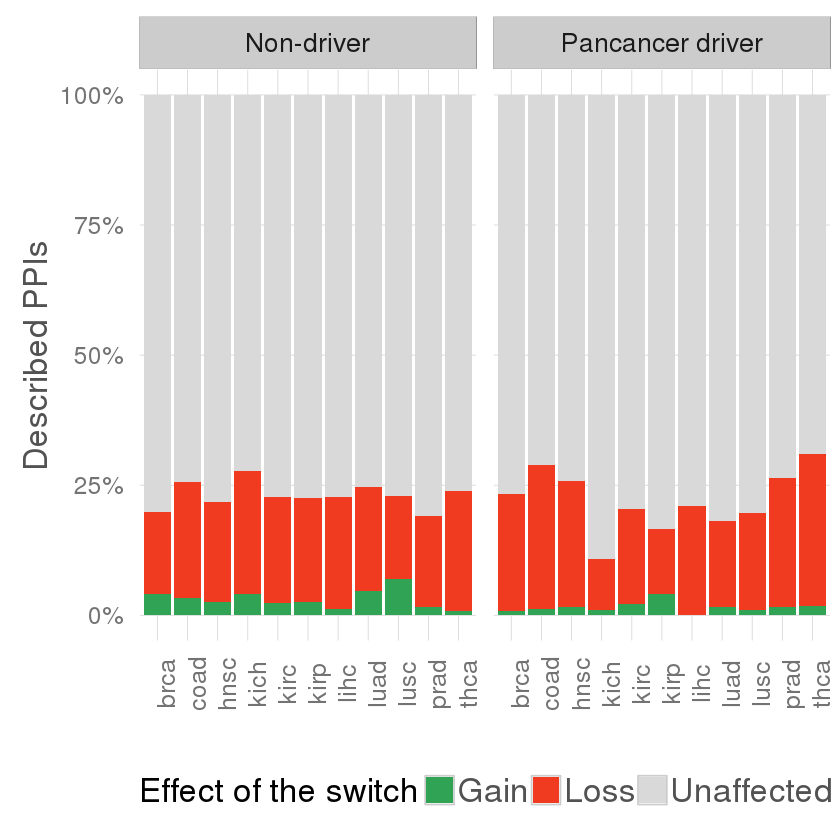

In [5]:
ppi.split %>%
    mutate(Driver = ifelse(Driver==1, "Pancancer driver", "Non-driver")) %>%
    ggplot(aes(x=Tumor,fill=What)) + 
        geom_bar(position="fill") +
        clean_theme() +
        labs(x="",y="Described PPIs",fill="Effect of the switch") +
        scale_fill_manual(values = ppiPalette) +
        theme(legend.position="bottom", axis.text.x = element_text(angle = 90)) +
        scale_y_continuous(labels = percent) +
        facet_grid(.~Driver)

ppi.split %>%
    select(Driver,What) %>%
    table %>%
    chisq.test

The same goes for the list of potential drivers: the enrichment is still there. However, it looks weaker. The signal is strong in the well curated set of drivers, and when adding potential drivers we are adding some noise.

## Candidate switches

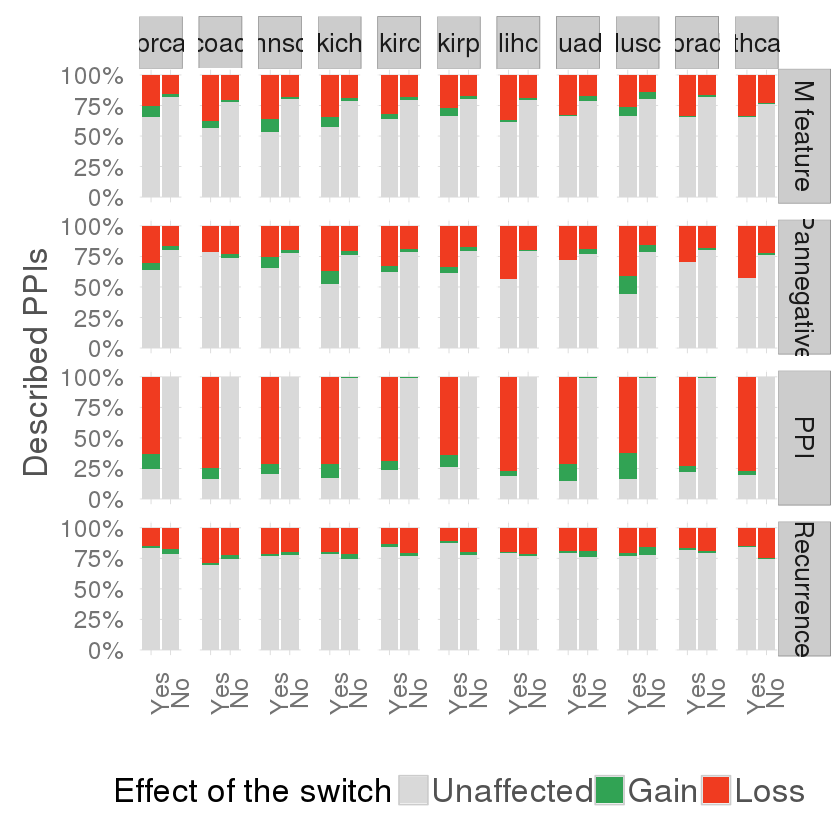

In [6]:
ppi.split %>%
    select(Tumor,What,Recurrence,Affects_mutated_feature,PPI,Pannegative) %>%
    # convert to long format and reannotate the columns
    reshape2::melt(id.vars = c("Tumor","What"),variable.name = "Indication", value.name = "Altered") %>%
    mutate(Altered = ifelse(Altered > 0,"Yes","No"),
           Altered = factor(Altered, levels=c("Yes","No")),
           What = factor(What,levels=c("Unaffected","Gain","Loss")),
           Indication = ifelse(Indication=="Affects_mutated_feature", "M feature", as.character(Indication))) %>%
    # plot
    ggplot(aes(x = Altered, fill = What)) + 
        geom_bar(position = "fill") +
        clean_theme() +
        labs(x="",y="Described PPIs",fill="Effect of the switch") +
        scale_fill_manual(values = ppiPalette) +
        theme(legend.position = "bottom", axis.text.x = element_text(angle = 90)) +
        scale_y_continuous(labels = percent) +
        facet_grid(Indication~Tumor)

We split the candidates by category. The most important change comes probably from the *M feature* candidates ie the candidates with domains likely to be in tumor drivers. Knowing that drivers have more interactions and are better studied, it is not surprising we are recovering this result: possibly the same domains that help drivers to become hubs allow other genes to do so. Hence, those switches are enriched both in gains and losses.

Recurrent switches do not have this bias though. We observe how they also tend to lose more interactions than the rest of the switches but gain less too. This reveals their possible impact on the PPI network and gives an explanation of their recurrence.

# Pancancer

In [7]:
# contradictory cases
gains <- ppi$Gain > 0
losses <- ppi$Loss > 0
unaffected <- ppi$Unaffected > 0

sum(gains & losses)
sum(unaffected & losses)
sum(unaffected & gains)

summary(ppi$Loss[losses])
summary(ppi$Gain[gains])
summary(ppi$Unaffected[unaffected])

[1] 0

[1] 3

[1] 0

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   4.000   4.006   6.000  11.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   3.127   4.000  10.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   3.000   4.000   4.397   6.000  11.000 

Most of the cases are coherent, hence we can keep using the tags.

## Categories
### Pancancer-drivers

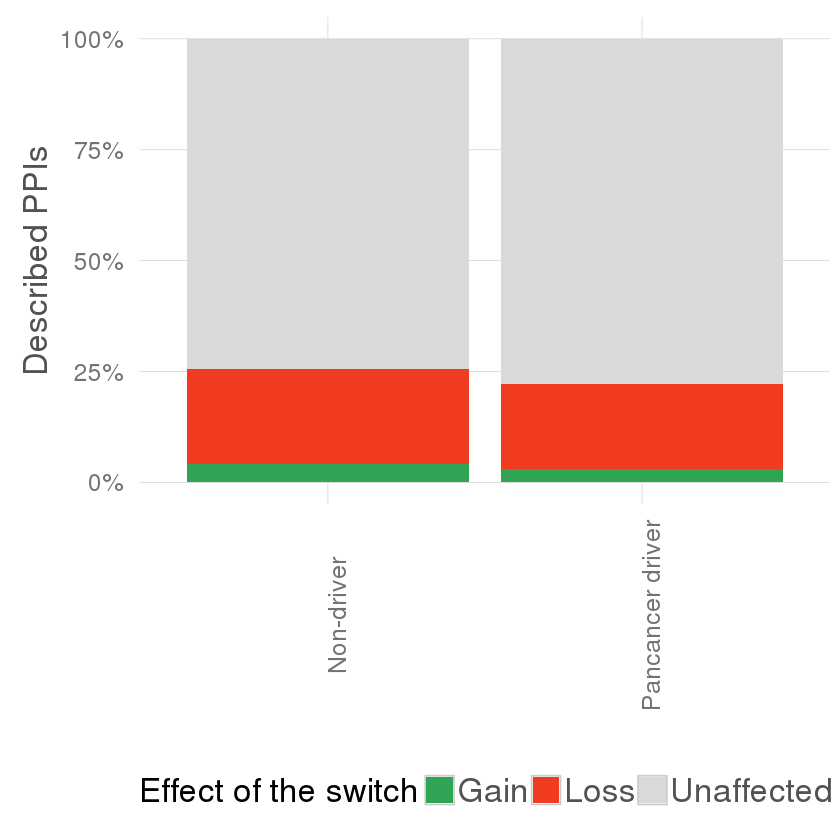

In [8]:
ppi %>%
    mutate(Driver = ifelse(Driver==1, "Pancancer driver", "Non-driver")) %>%
    select(Driver,Gain,Loss,Unaffected) %>%
    reshape2::melt(id.vars = "Driver", variable.name = "What", value.name = "Counts") %>%
    filter(Counts > 0) %>%
    mutate(Counts = as.numeric(Counts > 0)) %>%
    ggplot(aes(x=Driver,fill=What)) + 
        geom_bar(position="fill") +
        clean_theme() +
        labs(x="",y="Described PPIs",fill="Effect of the switch") +
        scale_fill_manual(values = ppiPalette) +
        theme(legend.position="bottom", axis.text.x = element_text(angle = 90)) +
        scale_y_continuous(labels = percent)

### Potus


	Pearson's Chi-squared test

data:  .
X-squared = 153.84, df = 2, p-value < 2.2e-16



	Pearson's Chi-squared test

data:  .
X-squared = 26.123, df = 2, p-value = 2.125e-06


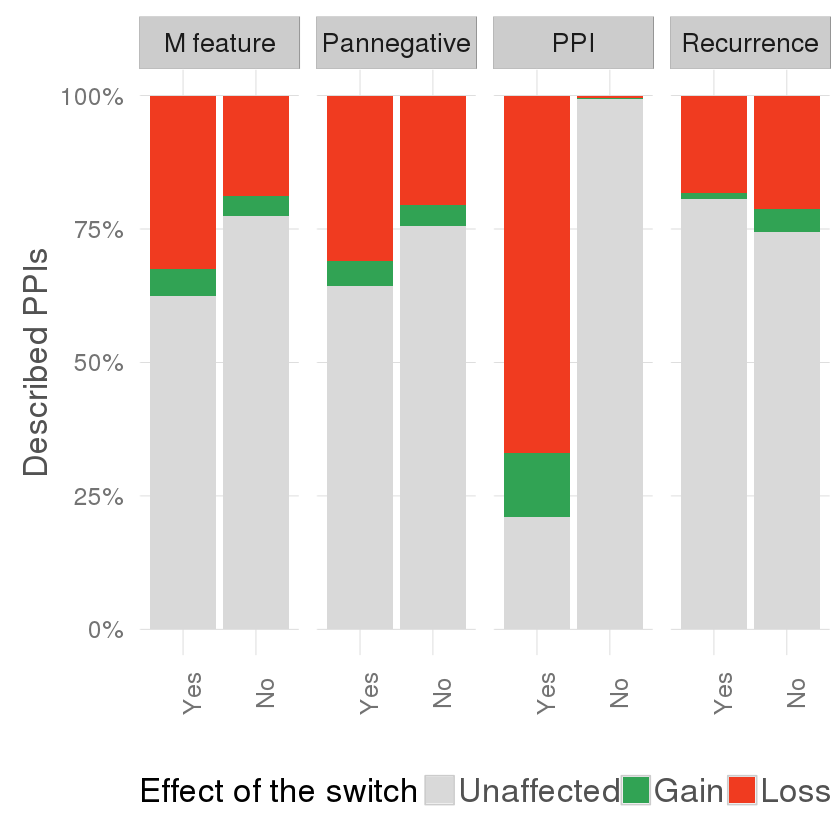

In [9]:
ppi.potus.pancancer <- ppi %>%
    select(Tag,Recurrence,Affects_mutated_feature,PPI,Pannegative) %>%
    # convert to long format and reannotate the columns
    reshape2::melt(id.vars = "Tag", variable.name = "Indication", value.name = "Altered") %>%
    mutate(Altered = ifelse(Altered > 0,"Yes","No"),
           Altered = factor(Altered, levels=c("Yes","No")),
           Tag = factor(Tag,levels=c("Unaffected","Gain","Loss")),
           Indication = ifelse(Indication=="Affects_mutated_feature", "M feature", as.character(Indication)))
    # plot
ppi.potus.pancancer %>%
    ggplot(aes(x = Altered, fill = Tag)) + 
        geom_bar(position = "fill") +
        clean_theme() +
        labs(x="",y="Described PPIs",fill="Effect of the switch") +
        scale_fill_manual(values = ppiPalette) +
        theme(legend.position = "bottom", axis.text.x = element_text(angle = 90)) +
        scale_y_continuous(labels = percent) +
        facet_grid(.~Indication)

ppi.potus.pancancer %>%
    filter(Indication == "M feature") %>%
    select(Altered,Tag) %>%
    table %>%
    chisq.test

ppi.potus.pancancer %>%
    filter(Indication == "Pannegative") %>%
    select(Altered,Tag) %>%
    table %>%
    chisq.test

This figure is a good summary of the tumor-specific one.

In [10]:
ppi %>% filter(Loss > 0 & PPI == 0)

,GeneId,Symbol,Normal_transcript,Tumor_transcript,partnerSymbol,Unaffected,Gain,Loss,Tag,Normal_protein,Tumor_protein,DriverAnnotation,Reliable,IsFunctional,Origin,Driver,Druggable,CDS_Normal,CDS_Tumor,CDS_change,UTR_change,Tumors,PatientNumber,Percentage,Patients_affected,Recurrence,PPI,Affects_mutated_feature,Pannegative,Candidate,MS.pam,M.pam,S.pam,N.pam,p.pam.me,MS.mut,M.mut,S.mut,N.mut,p.mut.o
1,10611,PDLIM5,uc003hti.2,uc003htj.2,GFI1B,0,0,1,Loss,Q96HC4,None,Nothing,1,1,Tumor,0,0,1,1,1,1,"kich,lusc",13,0.00292661,"8327T,8331T,8328T,8342T,8476T,8421T,8324T,8414T,8409T,8404T,8346T,2720T,A4CLT",0,0,0,0,0,0,26,12,3560,0.9165273,0,3,1,10,1
2,10611,PDLIM5,uc003hti.2,uc011cdy.1,GFI1B,0,0,1,Loss,Q96HC4,None,Nothing,1,1,Tumor,0,0,1,1,1,1,"kich,kirc,lusc",6,0.001350743,"8431T,3325T,4852T,5174T,5677T,1005T",0,0,0,0,0,0,26,4,3568,0.9713951,NA,NA,NA,NA,NA
3,10930,APOBEC2,uc003opl.2,uc010jxf.2,APOBEC1,0,0,1,Loss,Q9Y235,None,Nothing,1,1,Tumor,0,0,1,0,1,1,"brca,coad,hnsc,kich,kirc,kirp,lusc,thca",73,0.01643404,"A0DOT,A0DPT,A158T,A2FBT,A0C3T,A0H7T,6605T,7177T,8431T,5549T,6033T,6090T,5711T,5709T,A4JJT,5883T,A44BT,A40YT,A7SNT,A55ZT,8518T,7288T,6132T,A5W7T,A5QZT,7173T,A7VFT,A71UT,6797T,A562T,5878T,A6HPT,7966T,4114T,A75ZT,3473T,7837T,6792T,4113T,7583T,7129T,A7UZT,A6M9T,7046T,A6GDT,8516T,A5W8T,7128T,5885T,7839T,6796T,7584T,5903T,A7SMT,8312T,A561T,A6GET,A71VT,A5NHT,A5NKT,8500T,6795T,A5NJT,8195T,A854T,5876T,A5DUT,A856T,A5Z9T,7730T,A3DWT,A2NAT,A3ZGT",1,0,0,0,1,0,10,61,3527,0.842646,0,1,1,26,1
4,11244,ZHX1,uc003yqe.2,uc003yqg.2,ZHX3,0,0,5,Loss,Q9UKY1,None,d1,1,1,Tumor,0,0,1,0,1,1,"brca,coad,kich,kirc,luad,lusc",28,0.006303467,"A3XUT,A04PT,A1KRT,A5RWT,A0JLT,A54OT,6166T,8328T,8326T,8331T,8338T,8438T,8415T,8409T,8421T,4334T,4159T,4841T,4799T,3427T,4507T,2726T,A5HKT,4582T,2778T,4589T,3421T,7335T",0,0,1,0,1,0,25,23,3550,0.8514088,0,7,1,87,1
5,143689,PIWIL4,uc001pfa.2,uc009ywk.1,DICER1,0,0,1,Loss,Q7Z3Z4,None,d1,1,1,Tumor,0,0,1,0,1,1,"brca,hnsc,kirc,kirp,luad,lusc,prad",22,0.004952724,"A0AYT,7063T,6491T,A54DT,5706T,4842T,8098T,A5Y0T,A5NJT,6836T,8358T,6593T,6972T,4514T,8148T,A4JBT,A5MST,8065T,4599T,5507T,7232T,A632T",0,0,0,0,0,1,32,15,3550,0.9909652,1,4,0,41,0.1086957
6,2152,F3,uc001dqr.2,uc001dqp.2,F7,0,0,4,Loss,P13726,None,Nothing,1,1,Tumor,0,0,1,0,1,1,"brca,kirc,kirp,lihc,luad,lusc",24,0.005402972,"A2DOT,A2DAT,A0BFT,A14WT,4988T,4327T,4992T,5098T,5169T,4815T,4881T,4690T,4697T,5175T,3472T,A4NQT,A1ELT,A4BCT,7813T,8085T,6026T,A513T,A5HQT,A56UT",0,0,0,0,0,0,6,19,3573,0.9687096,NA,NA,NA,NA,NA
7,2152,F3,uc001dqr.2,uc001dqp.2,PLG,0,0,3,Loss,P13726,None,Nothing,1,1,Tumor,0,0,1,0,1,1,"brca,kirc,kirp,lihc,luad,lusc",24,0.005402972,"A2DOT,A2DAT,A0BFT,A14WT,4988T,4327T,4992T,5098T,5169T,4815T,4881T,4690T,4697T,5175T,3472T,A4NQT,A1ELT,A4BCT,7813T,8085T,6026T,A513T,A5HQT,A56UT",0,0,0,0,0,0,6,19,3573,0.9687096,NA,NA,NA,NA,NA
8,221662,RBM24,uc003nbz.3,uc011diz.1,A2BP1,0,0,2,Loss,Q9BX46,None,Nothing,1,1,Tumor,0,0,1,1,1,1,"hnsc,kich,kirc,luad,lusc,thca",9,0.002026114,"7235T,8421T,8404T,8334T,5982T,6849T,6743T,7335T,A2N5T",0,0,0,0,0,0,13,8,3577,0.9714305,NA,NA,NA,NA,NA
9,2244,FGB,uc003ioa.3,uc003ioc.3,LPA,0,0,1,Loss,P02675,None,Nothing,1,1,Tumor,0,0,1,1,1,1,"brca,kirc,lihc",7,0.001575867,"A1RHT,5681T,A73GT,5259T,A2HST,A3CJT,A39VT",0,0,0,0,0,0,24,7,3567,0.954194,NA,NA,NA,NA,NA
10,23406,COTL1,uc002fid.2,uc010chk.2,ACTA1,0,0,5,Loss,Q14019,None,Nothing,1,1,Tumor,0,0,1,0,1,1,"brca,kirc,kirp,luad,prad,thca",37,0.008329581,"A56DT,A5YMT,A3XVT,A572T,4334T,5191T,5085T,4697T,4813T,4842T,A4VXT,5702T,4821T,4841T,5678T,5100T,4811T,5886T,5885T,6795T,A562T,A47NT,A7VFT,A5E6T,A5QZT,A5DJT,7724T,7725T,7752T,A67OT,A6INT,A6ILT,A46FT,A6IOT,A4FRT,A22QT,A3ZQT",0,0,0,0,0,0,6,32,3560,0.9477741,NA,NA,NA,NA,NA


Those are the few switches were the change in PPI cannot be extrapolated to all tumor-types with this switch. Thay are the cases in the PPI grid, under "No PPI".

## Switches more affected by PPI changes

Selecting by Total


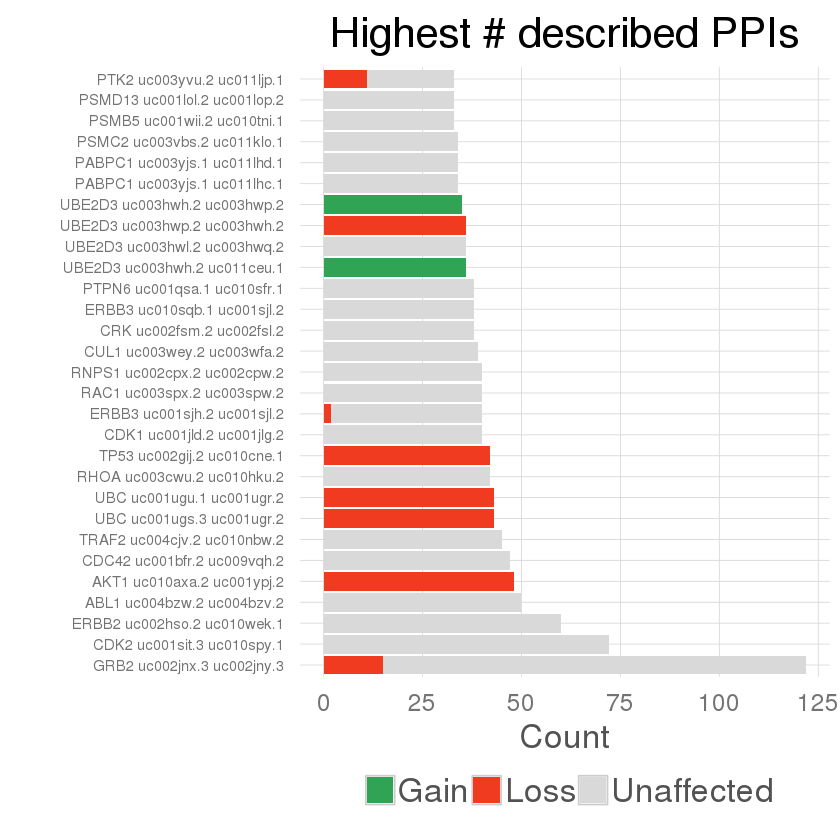

In [11]:
total <- ppi %>%
    count(Symbol, Normal_transcript, Tumor_transcript, Tag) %>% 
    ungroup %>%
    group_by(Symbol, Normal_transcript, Tumor_transcript) %>%
    summarise(Total = sum(n)) %>%
    ungroup

ppi %>%
    count(Symbol, Normal_transcript, Tumor_transcript, Tag) %>% 
    ungroup %>%
    merge(total) %>%
    arrange(desc(Total)) %>% 
    top_n(30)  %>%
    mutate(label = paste(Symbol, Normal_transcript, Tumor_transcript),
           label = factor(label, levels = unique(label))) %>%
    ggplot(aes(x = label, y = n, fill = Tag)) + 
        geom_bar(stat="identity") +
        scale_fill_manual(values = ppiPalette) +
        clean_theme() +
        labs(title = "Highest # described PPIs", x = "", y = "Count", fill = "") +
        theme(axis.text.y = element_text(size = 9), legend.position = "bottom") +
        coord_flip()

Selecting by n


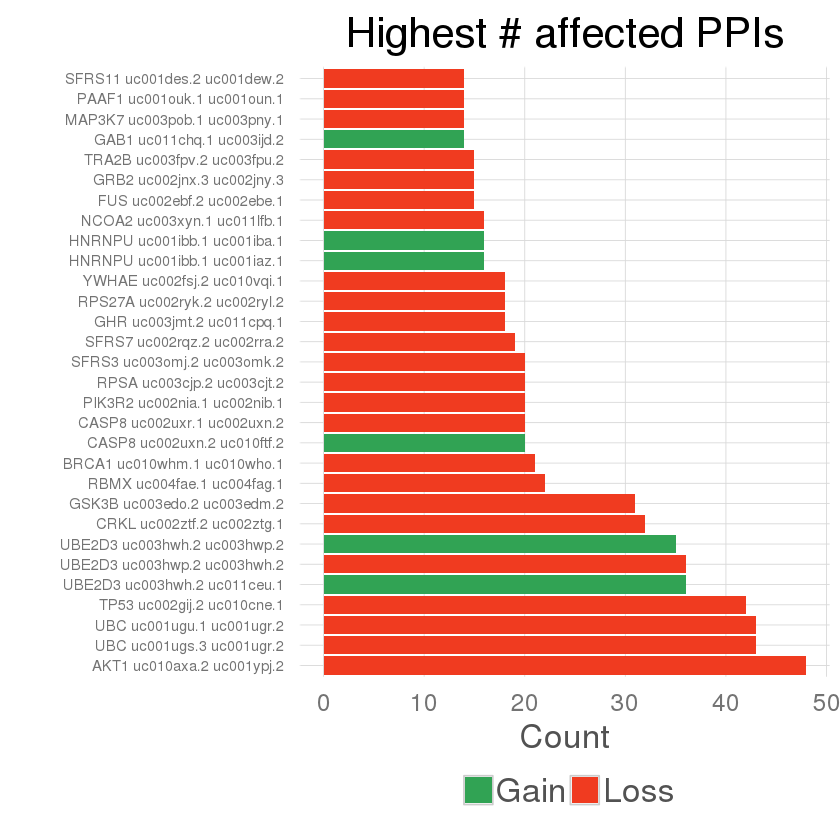

In [12]:
ppi %>%
    count(Symbol, Driver, Normal_transcript, Tumor_transcript, Tag) %>% 
    ungroup %>%
    arrange(desc(n)) %>% 
    filter(Tag!="Unaffected") %>% 
    top_n(30) %>%
    mutate(label = paste(Symbol, Normal_transcript, Tumor_transcript),
           label = factor(label, levels = label)) %>%
    ggplot(aes(x = label, y = n, fill = Tag)) + 
        geom_bar(stat="identity") +
        scale_fill_manual(values = ppiPalette) +
        clean_theme() +
        labs(title = "Highest # affected PPIs", x = "", y = "Count", fill = "") +
        theme(axis.text.y = element_text(size = 9), legend.position = "bottom") +
        coord_flip()

## Genes more affected by PPI changes due to switches in a partners

Selecting by n


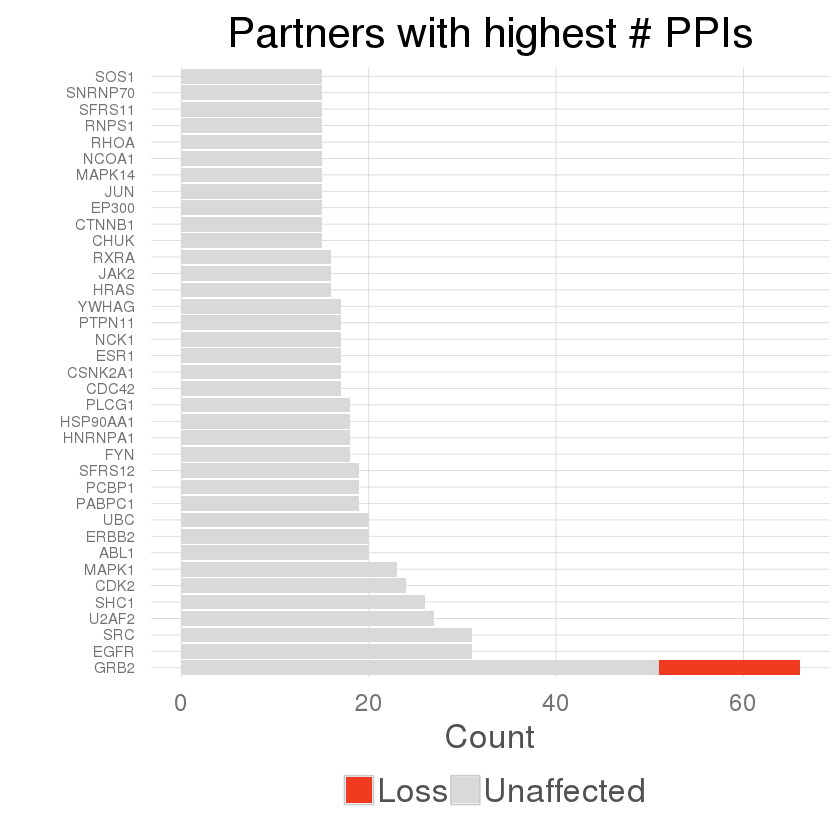

In [13]:
ppi %>%
    count(partnerSymbol,Tag) %>% 
    ungroup %>%
    arrange(desc(n)) %>% 
#     filter(Tag!="Unaffected") %>% 
    top_n(30) %>%
    mutate(partnerSymbol = factor(partnerSymbol, levels = unique(partnerSymbol))) %>%
    ggplot(aes(x = partnerSymbol, y = n, fill = Tag)) + 
        geom_bar(stat="identity") +
        scale_fill_manual(values = ppiPalette) +
        clean_theme() +
        labs(title = "Partners with highest # PPIs", x = "", y = "Count", fill = "") +
        theme(axis.text.y = element_text(size = 9), legend.position = "bottom") +
        coord_flip()

Selecting by n


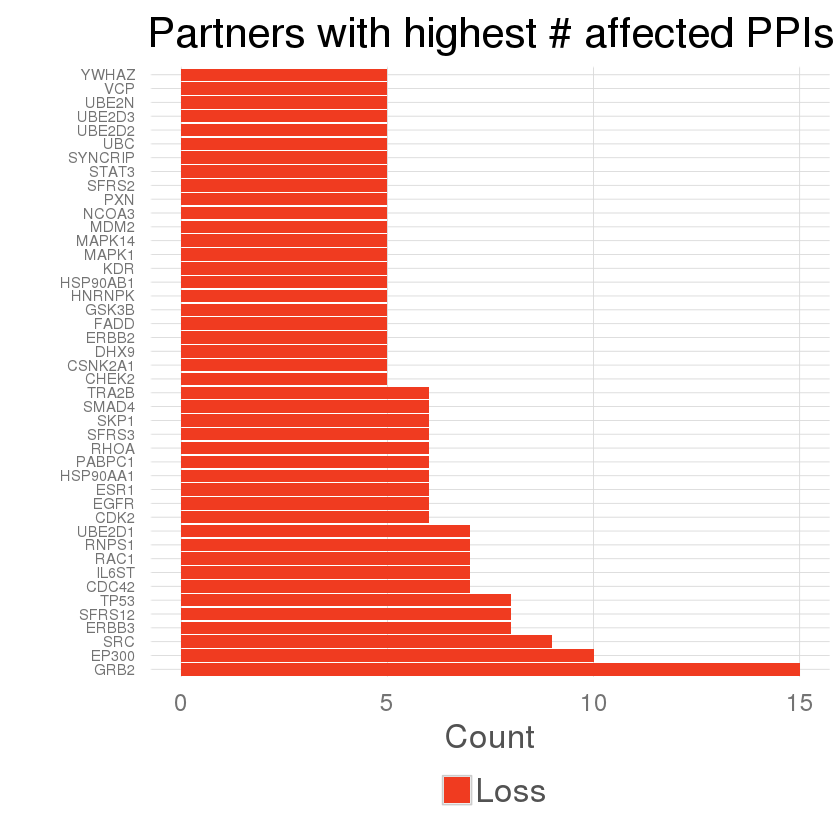

In [14]:
ppi %>%
    count(partnerSymbol,Tag) %>% 
    ungroup %>%
    arrange(desc(n)) %>% 
    filter(Tag!="Unaffected") %>% 
    top_n(30) %>%
    mutate(partnerSymbol = factor(partnerSymbol, levels = unique(partnerSymbol))) %>%
    ggplot(aes(x = partnerSymbol, y = n, fill = Tag)) + 
        geom_bar(stat="identity") +
        scale_fill_manual(values = ppiPalette) +
        clean_theme() +
        labs(title = "Partners with highest # affected PPIs", x = "", y = "Count", fill = "") +
        theme(axis.text.y = element_text(size = 9), legend.position = "bottom") +
        coord_flip()